# CN from Data Tool: Rainfall Runoff Analysis

## Libraries

In [5]:
library(lubridate)
library(plyr)
library(ggplot2)
library(zoo)

## Parameters
- area: Area of the basin
- data_start: Start of  the runoff values from the previous data table
- quantile_extremes: Quantile (i.e., non-exceedance probability) of runoff. Used to calculated the runoff threshold at which events are detected.
- Note that this method follows the upcoming revision to the National Hydrology Handbook
  - https://directives.sc.egov.usda.gov/OpenNonWebContent.aspx?content=41607.wba

In [6]:
#assign variables from prior workbooks
home = getwd()

huc_name = paste0(home,"/Inputs/huc12.txt")
huc12 = readChar(huc_name,file.info(huc_name)$size)

stream_gage_name = paste0(home,"/Inputs/stream_gage.txt")
stream_gage = readChar(stream_gage_name,file.info(stream_gage_name)$size)

rain_gage_name = paste0(home,"/Inputs/rain_gage.txt")
rain_gage = gsub("GHCND:","",readChar(rain_gage_name,file.info(rain_gage_name)$size))

gage_info_name = paste0(home,"/Outputs/",huc12,"/",stream_gage,"_info.txt")
gage_table = read.csv(gage_info_name, header = FALSE, sep = ";")

area <- gage_table[,1]
data_start <- gage_table[,3]
time_step_flow <- gage_table[,2]

Warning message in file(file, "rt"):
“cannot open file '/home/notebooks/Outputs/030902061500/02289500_info.txt': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


In [7]:
#gather parameters from Gage 1 notebook
areal_reduction = 1 #Based off of TP29P4 NOAA curve for the given area in sq. miles.

runoff_event_quantile = 0.5 #Quantile of runoff above which events are detected and recorded for analysis
runoff_cont_quantile = 0.05 #Quantile of runoff above which runoff adjancent (in time) to  detected event is considered part of the detected event.

### Load the USGS flow data 

In [32]:
df = read.csv(paste0("Outputs/",huc12,"/","USGS_",stream_gage,".csv"), header=TRUE)
df$Year  = year(ymd_hms(df$dateTime))
df$Month = month(ymd_hms(df$dateTime))
df$Day   = day(ymd_hms(df$dateTime))

df.daily = ddply(df, .(Year, Month, Day), summarise, site_no= stream_gage, Flow=sum(flow), Baseflow=sum(baseflow))
df.daily$Flow[is.na(df.daily$Baseflow)] = NA
df.daily$ymd = with(df.daily, ymd(Year*10000+Month*100+Day))
#Multiple by 10000 and 100 to convert to the ymd format in R

head(df.daily)
# tail(df.daily)

,Year,Month,Day,site_no,Flow,Baseflow,ymd
,<dbl>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<date>
1,2017,12,31,01196210,NA,NA,2017-12-31
2,2018,1,1,01196210,143.00,131.172162,2018-01-01
3,2018,1,2,01196210,129.81,125.760000,2018-01-02
4,2018,1,3,01196210,137.16,124.214955,2018-01-03
5,2018,1,4,01196210,107.26,87.941152,2018-01-04
6,2018,1,5,01196210,4.40,3.596336,2018-01-05


### Calculate the runoff as Daily Flow minus the Daily Baseflow

In [33]:
# to be consistent with precipitation (mm) must convert flow from daily accumulated minute timesteps cfs to mm
#27878400 sq feet in a square mile
# 304.8 mm in a foot

#daily runoff in mm
df.daily$Runoff = (df.daily$Flow - df.daily$Baseflow) * 60 * time_step_flow * 304.8 / (area*27878400)
summary(df.daily$Runoff)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
-0.30703  0.04276  0.13021  0.91397  0.54222 50.36377        1 

### Download the precipitation data and calculate months with Snow

- Find gages via the CN Gage 1 Notebook
  - Select gages with records that both
    - Overlap the gage record and
    - Are nearby the basin of interest
    - Have a high coverage (complete record) of 80-percent or greater.

In [8]:
#list rain gage for reference
paste(rain_gage)

[1] "US1FLMD0042"

In [9]:
stn.id = rain_gage
fname = paste0("https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/",stn.id,".csv")
if(!file.exists(paste0(stn.id,".csv"))){
    download.file(url=fname,destfile=paste0(stn.id,".csv"))
}

prcp = read.csv(paste0(stn.id,".csv"), header=TRUE)

#Making a subset of the precipitation station data record
#Screens out everything before the data_start of the stream flow data
df.prcp = subset(prcp, ymd(prcp$DATE) > ymd(data_start), select=c("STATION","DATE","LATITUDE","LONGITUDE","ELEVATION","PRCP","PRCP_ATTRIBUTES","SNOW","SNOW_ATTRIBUTES"))

#Define the ymd variable baed on the data column
df.prcp$ymd = ymd(df.prcp$DATE)

df.prcp$PRCP[is.na(df.prcp$PRCP)] = 0
#Have to divide by 10 since 152 in the data is actually 15.2 mm of rain.
df.prcp$PRCP = (df.prcp$PRCP / 10) * areal_reduction

#-----------------Not used in later calcs----------------- but informative
#Look at each moneth and when snow is greater than 0. Take unique values and sort.
snow.months = sort(unique(month(ymd(df.prcp$DATE))[df.prcp$SNOW > 0]))
snow.count = ddply(df.prcp, .(month(ymd(DATE))), summarise, count=sum(SNOW > 0, na.rm=TRUE)+0, avg=(sum(SNOW > 0, na.rm=TRUE)+0)/length(unique(year(ymd(DATE)))))

snow.count
month_nosnow = which(snow.count$avg < 2)
month_start = min(month_nosnow)
month_end   = max(month_nosnow)
month_nosnow
#-------------------------------------------------------


#Precipitation Stats
summary(df.prcp$PRCP[df.prcp$PRCP > 0])
NROW(na.omit(df.prcp$PRCP))

ERROR: Error in lapply(list(...), .num_to_date): object 'data_start' not found


## Define new DataFrame
- Set one column to ymd from the first day in the from to the last day in the dataframe
- Do this so not to skip missing data

In [36]:
df.full = data.frame(ymd=seq.Date(from=ymd(df.daily$ymd[1]), to=ymd(df.daily$ymd[nrow(df.daily)]), by="day"))
#join streamflow
df.full = join(df.full, df.daily, by="ymd")
#join precip
df.full = join(df.full, subset(df.prcp, select=c('ymd','PRCP')), by="ymd")
summary(df.full['ymd'])

#hist(df.full$Runoff)

      ymd            
 Min.   :2017-12-31  
 1st Qu.:2019-03-31  
 Median :2020-06-29  
 Mean   :2020-06-29  
 3rd Qu.:2021-09-28  
 Max.   :2022-12-28  

### Aggregate Event Rainfall and Runoff

- Runoff is counted from when the threshold (quantile value) is exceeded until either the 'ndays_runoff' has expired or another event is desired. Runoff is added to this count for days before the threshold, if the runoff is greater than zero and is not already part of another event. Days before is given by the lag value based on the USGS HYSEP equation for the runoff concentration time.|

- Rainfalll is counted from when the threshold of runoff is exceeded until either the 'ndays_precip' has expired or another runoff event is detected. Rainfall is added to this count for days before the threshold, if the rainfall is greater than zero and is not already part of another event. Days before is given teh the lag value.


In [37]:
ndays_runoff = 7 #Set to a large value to account for all runoff after an event
delta_precip = ceiling(area^.2) #Based on the time of concentration for a pulse of precipitation as described in HYSEP of the USGS.
ndays_precip = ndays_runoff - delta_precip
lag=floor(area^.2) #

#Define the thresholds based on the quantiles
runoff_event_thresh = quantile(df.full$Runoff[df.full$Runoff > 0], probs=runoff_event_quantile, na.rm=TRUE)
runoff_cont_thresh = quantile(df.full$Runoff[df.full$Runoff > 0], probs=runoff_cont_quantile, na.rm=TRUE)

print(runoff_event_thresh)
print(runoff_cont_thresh)

df.full$PRCP[is.na(df.full$PRCP)] = 0
df.full$Runoff[is.na(df.full$Runoff)] = 0

df.full$PRCP_SUM = df.full$PRCP
df.full$Runoff_SUM = df.full$Runoff
df.full$Runoff_LAG = df.full$Runoff
df.full$PRCP_LAG = df.full$PRCP

print(summary(df.full$PRCP_SUM))

for(i in 1:(nrow(df.full)-(ndays_runoff))){
    if(df.full$Runoff_SUM[i] >= runoff_event_thresh){
        for(k in 1:(ndays_runoff)){
            if(df.full$Runoff_SUM[i+k] < runoff_cont_thresh & df.full$Runoff_SUM[i+k] > runoff_event_thresh){
                break
            }
            df.full$Runoff_SUM[i] = sum(df.full$Runoff_SUM[i:(i+k-1)])
            df.full$Runoff_LAG[i+k-1] = 0
            if(k>1){
                df.full$Runoff_SUM[i+k-1]=0
            }
        }
        if(i > (lag+1) & lag > 0){
            df.full$Runoff_SUM[i] = df.full$Runoff_SUM[i]+ sum(df.full$Runoff_LAG[(i-lag):(i-1)])
                }
            }
    else{
        df.full$Runoff_SUM[i] = 0
    }
}

for(i in 1:(nrow(df.full)-(ndays_runoff))){
    if(df.full$Runoff_SUM[i] > 0){
        for(j in 1:(ndays_precip)){
            if(df.full$Runoff_SUM[i+j] >0){
                break
            }
            df.full$PRCP_SUM[i] = sum(df.full$PRCP_SUM[i:(i+j-1)])
            df.full$PRCP_LAG[i+j-1] = 0
            if(j>1){
                df.full$PRCP_SUM[i+j-1] = 0
            }
            
        } 
        if(i > (lag+1)){
            df.full$PRCP_SUM[i] =df.full$PRCP_SUM[i]+ sum(df.full$PRCP_LAG[(i-lag):(i-1)])
            }
    }else{
        df.full$PRCP_SUM[i] = 0
        }
}

      50% 
0.1406269 
        5% 
0.01369043 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.000   3.433   1.300 139.400 


,ymd,Year,Month,Day,site_no,Flow,Baseflow,Runoff,PRCP,PRCP_SUM,Runoff_SUM,Runoff_LAG,PRCP_LAG
,<date>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
24,2018-01-23,2018,1,23,01196210,1106.43,326.5263,3.7253182,9.1,16.0,8.4758113,0,0
48,2018-02-16,2018,2,16,01196210,575.67,492.3469,0.3980045,0.0,3.0,2.5064053,0,0
62,2018-03-02,2018,3,2,01196210,1378.18,520.6080,4.0963117,15.5,15.5,11.6647017,0,0
69,2018-03-09,2018,3,9,01196210,651.17,508.0020,0.6838619,0.0,31.8,2.1919801,0,0
83,2018-03-23,2018,3,23,01196210,477.54,439.8123,0.1802117,0.0,3.0,0.3354442,0,0
94,2018-04-03,2018,4,3,01196210,528.69,394.5115,0.6409222,8.4,29.7,3.1500739,0,0


[1] 175

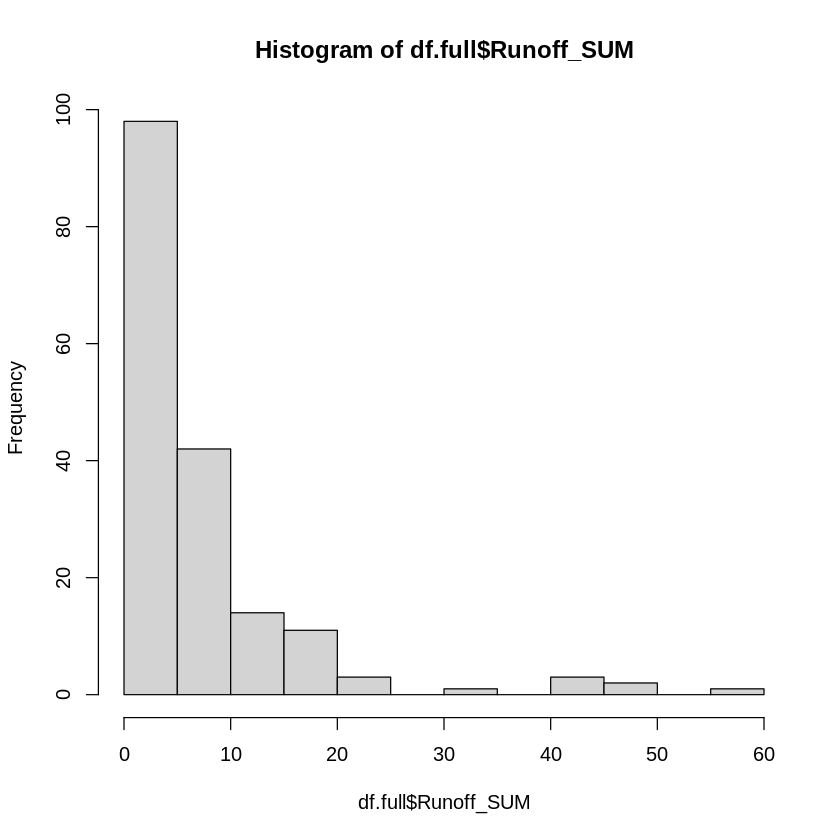

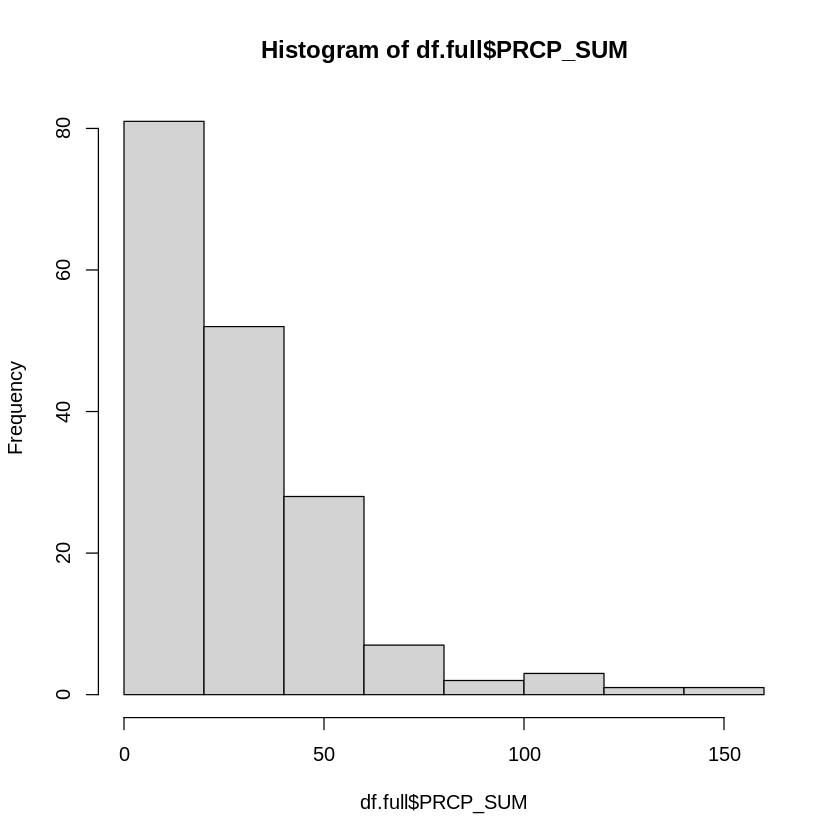

In [38]:
#Only take events where precipitation is greater than Runoff. Avoids cases of snowfall
df.full = df.full[which(df.full$PRCP_SUM > df.full$Runoff_SUM),]

#Only consider events where runoff is greater than 0.
df.full = df.full[which(df.full$Runoff_SUM > 0),]
head(df.full)

#Count the final number of events
NROW(na.omit(df.full))

#Examine the histograms of runoff and precipitation
hist(df.full$Runoff_SUM);hist(df.full$PRCP_SUM);

### Rank and sort the rainfall and runoff from smallest to largest values
- Ranked/sorted value then are repaired to create a synthetic rainfall/runoff curve.
- Curve is then plotted based on rainfall vs the corresonding CN value

,flow,prcp,S,CN
,<dbl>,<dbl>,<dbl>,<dbl>
1,57.84735,153.4,143.86853,63.84018
2,49.47387,124.9,110.68668,69.64883
3,48.94930,115.4,94.02343,72.98359
4,44.71821,110.2,94.87419,72.80562
5,43.86688,104.6,86.46037,74.60486
6,41.71051,91.2,67.20407,79.07745


,flow,prcp,S,CN
Min.,0.3297791,1.10000,1.299788,63.84018
1st Qu.,1.5023956,10.60000,20.886395,80.97657
Median,3.7697466,22.80000,41.429386,85.97655
Mean,6.9866792,28.85029,42.591180,86.21539
3rd Qu.,8.4700763,39.40000,59.671018,92.40181
Max.,57.8473469,153.40000,143.868529,99.49088


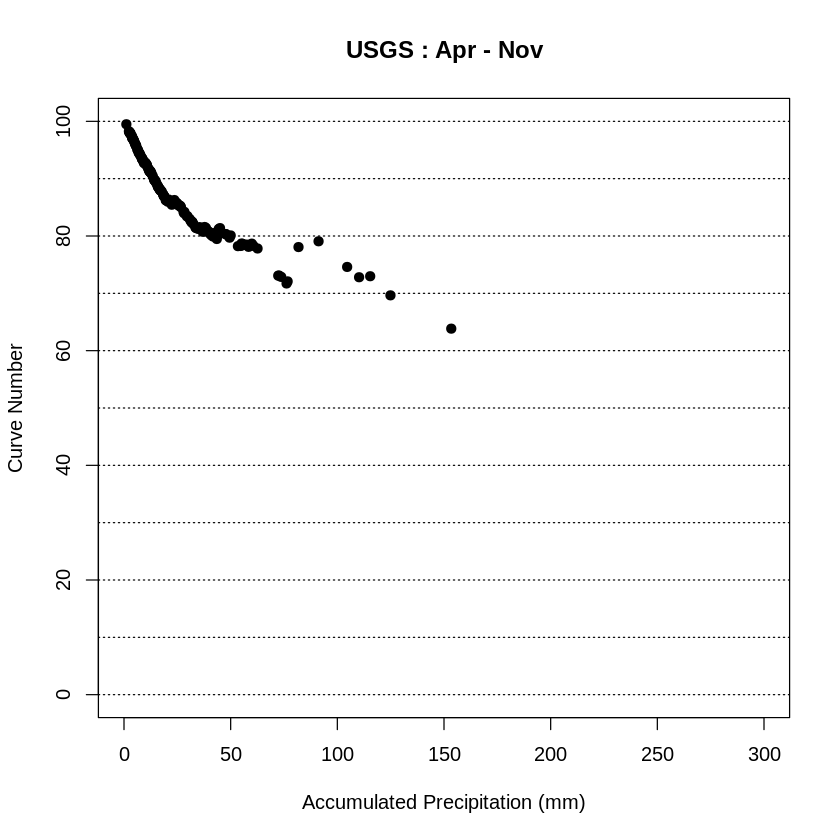

In [39]:
rankedFlow = rev(sort(df.full$Runoff_SUM))
rankedPrcp = rev(sort(df.full$PRCP_SUM))

ranked = data.frame(flow = rankedFlow, prcp = rankedPrcp)
ranked$S = 5 * (ranked$prcp + 2*ranked$flow - sqrt((4*ranked$flow^2) + (5*ranked$prcp*ranked$flow)))
ranked$CN = 25400 / (ranked$S + 254)#100 / (1 + (10^log(ranked$S)) / 254)
ranked = subset(ranked, CN < 100)

plot(ranked$prcp, ranked$CN, pch=19, xlab="Accumulated Precipitation (mm)", ylab="Curve Number",
     ylim=c(0,100),xlim=c(0,300), main=paste0("USGS ", unique(na.omit(df.full$stream_gage)),": ",
                                               month.abb[month_start]," - ", month.abb[month_end]))
abline(h=seq(from =0 , to = 100, by = 10),lwd=1,lty=3)
head(ranked)
apply(ranked, 2, summary)

### Fit the equation (for the asymptotic CN) to the data (ranked/sorted)

In [40]:
#Fit exponential model to data
penalty.exp = 1 #Weights higher precipitation value when fitting the CN curve to the data.

firstorder<-function(C0,k, PRCP, CN){
    C1 = 100 - C0
    ynew<-C0 + C1*exp(-k*PRCP)
    RMSE<-sum((ynew-CN)^2 * (PRCP-min(PRCP))^penalty.exp,na.rm=TRUE)
    return(RMSE)
}

#Initial parameter values
params<-c(20, 2)

# Seasonal fit
ranked2 = ranked #subset(ranked, CN <80) #ranked
expFit = optim(params, function(x) firstorder(C0=x[1], k=x[2], PRCP=ranked2$prcp, CN=ranked2$CN))
xx = seq(0,500,1)
yy = expFit$par[1] + (100 - expFit$par[1])*exp(-expFit$par[2]*xx)
      

ninety_pct_flow = quantile(ranked$flow, probs=0.9,names= FALSE)
ninety_pct_prcp = quantile(ranked$prcp, probs=0.9,names= FALSE)

### Plot the equation fit

[1] "C(P) = 69.7 + 30.32*exp(-0.025*P)"


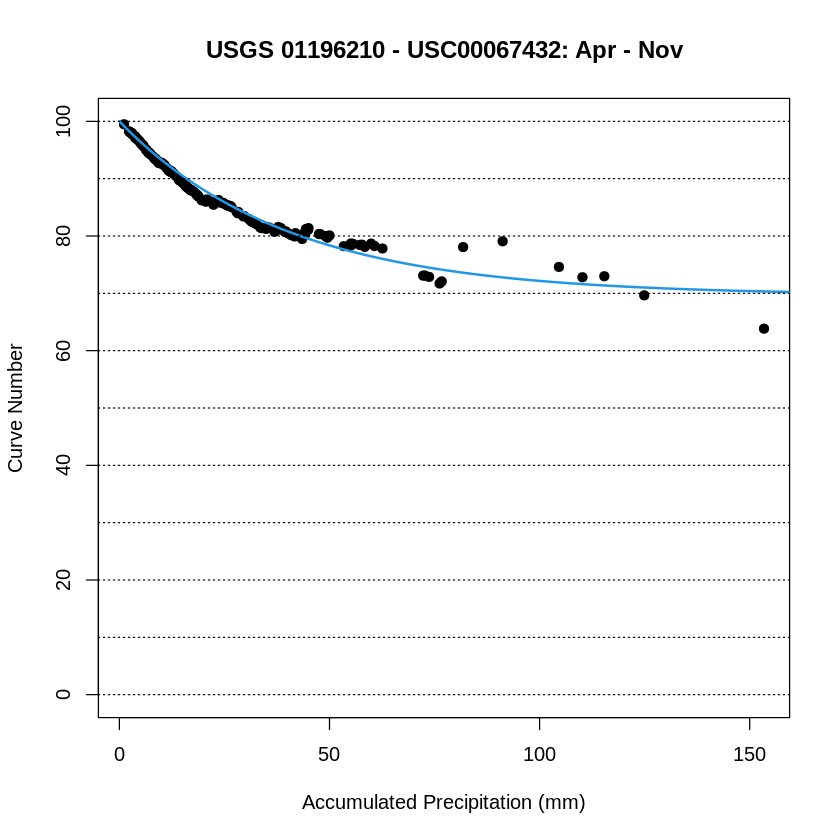

In [41]:
plot(ranked$prcp, ranked$CN, pch=19, xlab="Accumulated Precipitation (mm)", ylab="Curve Number",
     ylim=c(0,100), #xlim=c(0,200), 
     main=paste0("USGS ", stream_gage," - ",stn.id,": ", month.abb[month_start], " - ", month.abb[month_end]))
lines(xx,yy, lwd=2, col=4)
#grid(NA,20,lwd=2)
frml = paste0("C(P) = ",round(expFit$par[1],digits=1)," + ", (100-round(expFit$par[1], digits=2)),"*exp(-",round(expFit$par[2],digits=4),"*P)")
print(frml)

CN.mean = mean(ranked$CN[which(ranked$CN < quantile(ranked$CN, probs=0.025))], na.rm=TRUE)
abline(h=seq(from =0 , to = 100, by = 10),lwd=1,lty=3)

### Save png

In [42]:
jpeg(paste0(home,'/Outputs/',huc12,'/',stream_gage,'_',rain_gage,'_plot.jpg'))
plot(ranked$prcp, ranked$CN, pch=19, xlab="Accumulated Precipitation (mm)", ylab="Curve Number",
     ylim=c(0,100), #xlim=c(0,200), 
     main=paste0("USGS ", stream_gage," - ",stn.id,": ", month.abb[month_start], " - ", month.abb[month_end]))
lines(xx,yy, lwd=2, col=4)
#grid(NA,20,lwd=2)
frml = paste0("C(P) = ",round(expFit$par[1],digits=2)," + ", (100-round(expFit$par[1], digits=2)),"*exp(-",round(expFit$par[2],digits=4),"*P)")
#print(frml)

CN.mean = mean(ranked$CN[which(ranked$CN < quantile(ranked$CN, probs=0.025))], na.rm=TRUE)
abline(h=seq(from =0 , to = 100, by = 10),lwd=1,lty=3)

# text(x=quantile(ranked$prcp, probs=0.55), y=52,labels=paste0("CN = ",round(CN.mean,digits=1)), cex=1.25)
# text(x=quantile(ranked$prcp, probs=0.95), y=62, labels=frml, cex=1.25
dev.off()

png 
  2

## Metrics

### A(1) from journal. High % = confidence in the stability of the CN estimate
### Journal shows range of 89-98%

In [43]:
S_90 = 5 * (ninety_pct_prcp + 2*ninety_pct_flow - sqrt((4*ninety_pct_flow^2) + (5*ninety_pct_prcp*ninety_pct_flow)))
CN_90 = 25400 / (S_90 + 254) #100 / (1 + (10^log(ranked$S)) / 254)
paste0('A(1) value is about: ', 100*round(expFit$par[1]/CN_90,digits=2),'%')

[1] "A(1) value is about: 89%"

### A(2) from journal. High % = confidence in the hydrologically defined stability of the fit.
### Journal shows range of 24-78%

In [44]:
# find 10 nearest data points at the 90th percentile
closest_index = strtoi(rownames(ranked[which.min(abs(ninety_pct_prcp - ranked$prcp)),]))

In [45]:
mini_ranked = ranked[(closest_index-5):(closest_index+5),]

In [46]:
fit1 <- lm(mini_ranked$flow~mini_ranked$prcp,data=mini_ranked) #linear

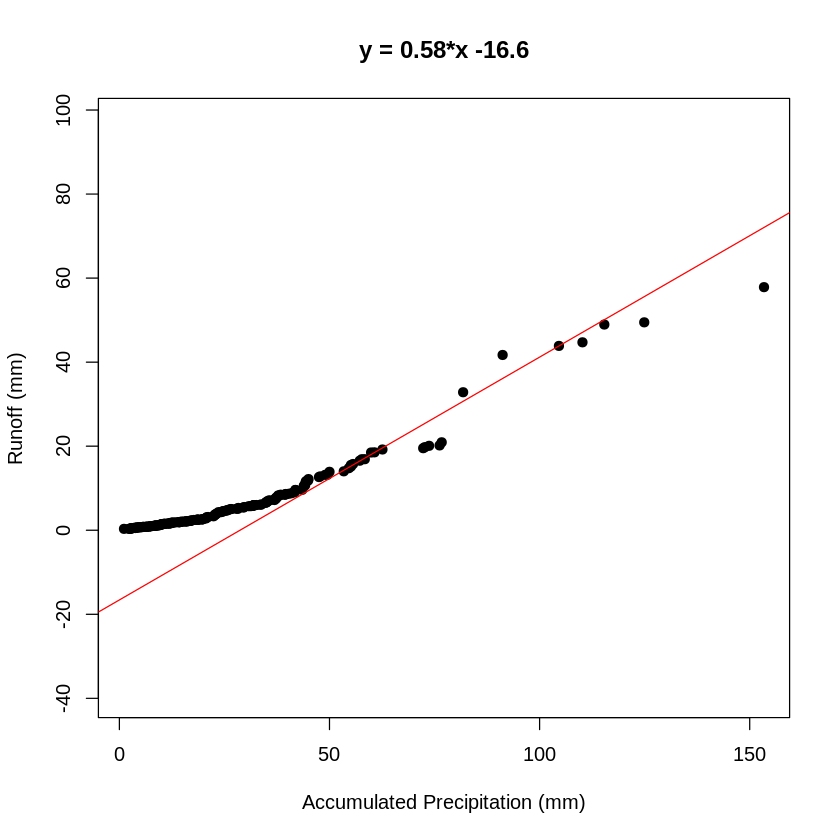

In [51]:
eq = paste0("y = ", round(coeff[2],2), "*x ", round(coeff[1],1))
plot(ranked$prcp, ranked$flow,pch=19, xlab="Accumulated Precipitation (mm)", ylab="Runoff (mm)",asp=1,main=eq)
abline(fit1, col='red')

In [50]:
coeff = coefficients(fit1)
paste0('A(2) value is about: ', 100*round(coeff[2],2),'%')

[1] "A(2) value is about: 58%"

---
## End